<a id=table_contents></a>
## Table of contents

1. [Import packages](#packages)
<br>

2. [Default parameters](#default_parameters)
<br>

3. [Exploratory Data Analysis and Feature Engineering](#eda)<br>
    3.1 [Outliers](#outliers)<br>
    3.2 [One-hot-encoding](#ohc)<br>
    3.3 [Key findings](#find)<br>
    <br>
    
4. [Linear regression - baseline](#lin_reg_basel)<br>
    4.1 [Split data - Kfold cross validation](#kfold)<br>
    4.2 [Numeric data only](#lin_reg_bas_num)<br>
    4.3 [One-hot-encoding data](#lin_reg_bas_ohc)<br>
    4.4 [One-hot-encoding data - smaller dataframe](#lin_reg_bas_ohc_short)<br>
    4.5 [Key findings](#lin_reg_bas_find)<br>
    <br>
    
5. [Linear regression - polynomial features](#lin_reg_pol)<br>
    5.1 [Numeric data only](#lin_reg_pol_num)<br>
    5.2 [One-hot-encoding data - smaller dataframe](#lin_reg_pol_ohc_short)<br>
    5.3 [Key findings](#lin_reg_pol_find)<br>
    <br>
    
6. [Linear regression - regularisation](#lin_reg_reg)<br>
    6.1 [Numeric data only](#lin_reg_reg_num)<br>
    6.2 [One-hot-encoding data](#lin_reg_reg_ohc)<br>
    6.3 [One-hot-encoding data - smaller dataframe](#lin_reg_reg_ohc_short)<br>
    6.4 [Ridge regression - Best fit](#lin_reg_reg_best)<br>
    6.5 [Key findings](#lin_reg_reg_find)<br>
    <br>
    
7. [Key insights, recommendations and next steps](#insights)


<a id='packages'></a>

# 1. Import packages

In [1]:
import matplotlib  # Used to set default paremeters
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm  # statistical modelling package
from matplotlib import rcParams  # Used to set default paremeters
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    LeaveOneOut,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

<a id='default_parameters'></a>

# 2. Figures default parameters

The cell below defines the default values for three different features of the figures included in this notebook, such as theme style, font and font size for the labels and titles of the figures.

In [2]:
sns.set_theme(style="darkgrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# TODO 


<a id='eda'></a>

# 3. Exploratory Data Analysis and Feature Engineering

This section includes the necessary steps to perform exploratory data analysis. The intial plan is to understand the relationship between the features, remove outliers and encode the data to create a model that include all the features.

The first step is to load the dataset. The chosen dataset presents the information about second-hand Audi cars registered in the UK. The car features, i.e. the columns, described in the dataset are as follows:

* Model. Car model.
* Year. Year the car was sold.
* Price. Car price in £.
* Tranmission. Transmission type
* Mileage. Miles the car had at the time it was purchased
* Fuel type. Type of fuel or powertrain (hybrid cars are included)
* Tax. Tax paid to register the car in £.
* Mpg. Miles per gallon.
* EngineSize. Size of the engine in litres.

Let's import the dataset and have a look at it:

In [3]:
data = pd.read_csv("audi.csv")

data.sample(n=7)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
4517,Q3,2019,25490,Manual,11130,Diesel,145,42.8,2.0
8471,A3,2019,21930,Automatic,16581,Petrol,150,42.2,1.5
6136,A5,2019,24970,Automatic,5415,Petrol,145,40.4,2.0
1388,A7,2016,19990,Semi-Auto,27386,Diesel,125,61.4,3.0
10175,A6,2010,6999,Manual,75000,Diesel,160,49.6,2.0
1780,A6,2018,27500,Semi-Auto,7825,Diesel,145,50.4,2.0
7883,A6,2011,8950,Automatic,116000,Diesel,200,47.1,3.0


This dataset has already been cleaned and there are no null values.

In [4]:
data.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Let's have a look at the column types

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [6]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


One can understand how the different features are related using a pairplot.

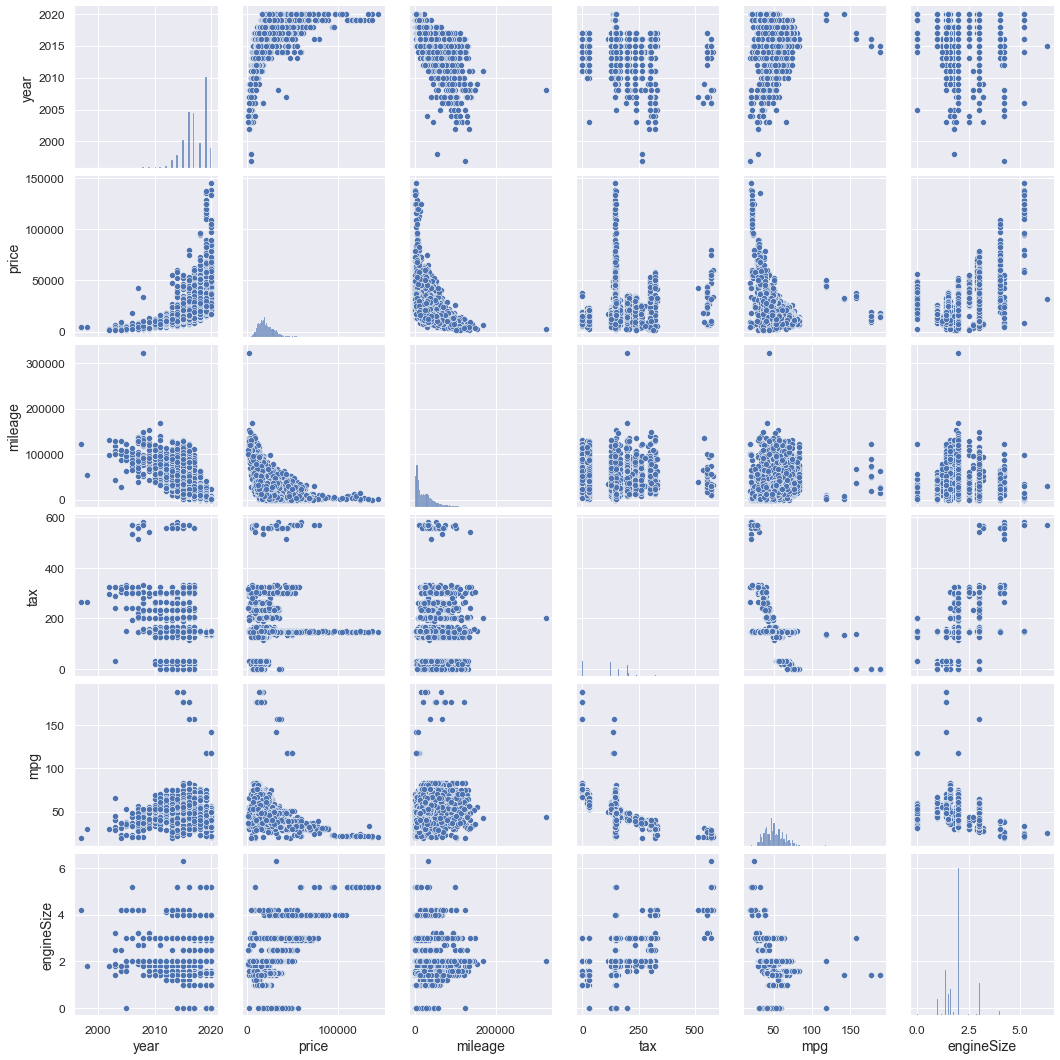

In [7]:
sns.pairplot(data=data.loc[:, "year":"engineSize"])

We can plot the correlation values to gain a better understanding of the relationship between features:

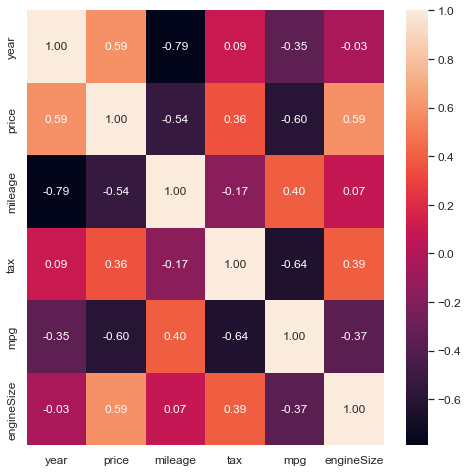

In [8]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f");

<a id='outliers'></a>

## 3.1 Outliers

Outliers can be identified using boxplots. Let's begin by generating the plots using the original dataset:

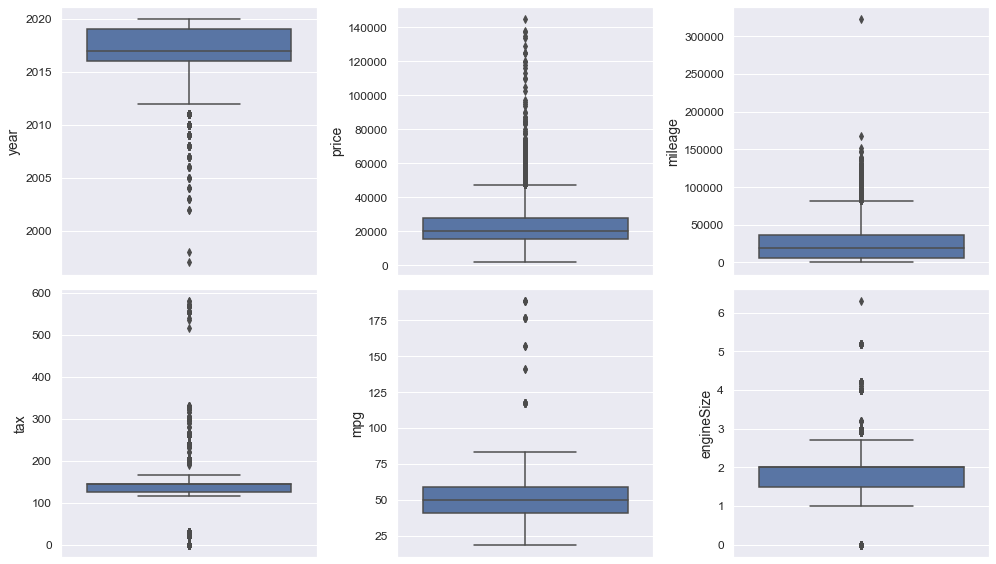

In [9]:
mask = data.dtypes != object

fig, ax = plt.subplots(2, 3, figsize=(14, 8))
ax = ax.flatten()

for ind, column_name in enumerate(data.columns[mask]):
    sns.boxplot(ax=ax[ind], y=column_name, data=data)

fig.tight_layout()

From those graphs, we can see outliers in multiple features:

* Year. The cars registered before the year 2000 will be removed
* Mileage. The values beyond 200,000 miles will be removed
* Mpg. The values above 150 mpg will be removed
* EngineSize. The values above 5 litres and below 0.25 litres will be removed

In [10]:
data = data.drop(data[data["engineSize"] > 5].index).reset_index(drop=True)
data = data.drop(data[data["engineSize"] < 0.25].index).reset_index(drop=True)

data = data.drop(data[data["mpg"] > 150].index).reset_index(drop=True)

data = data.drop(data[data["year"] < 2000].index).reset_index(drop=True)

data = data.drop(data[data["mileage"] > 200000].index).reset_index(drop=True)

We can generate the boxplots again to see the new distribution of the data:

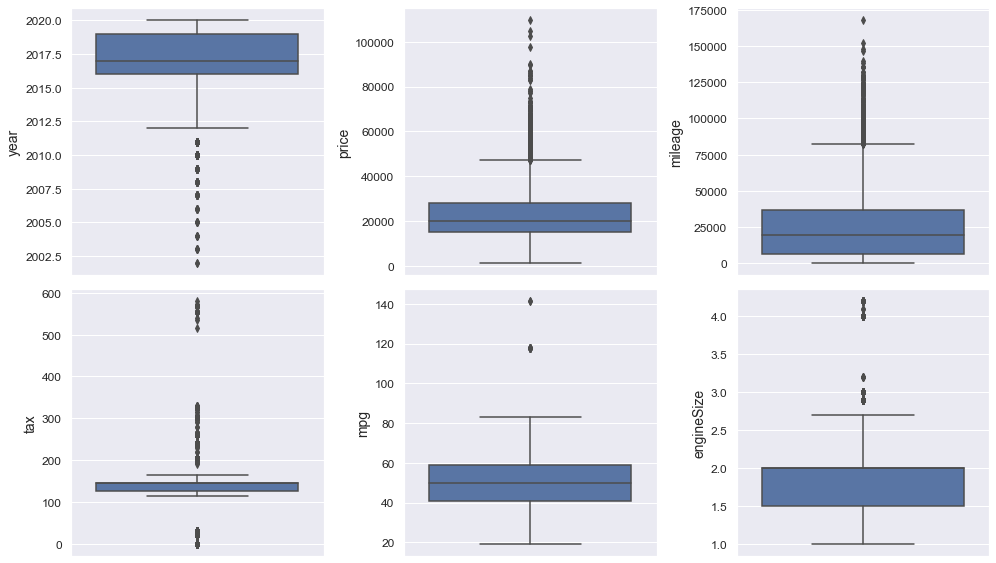

In [11]:
mask = data.dtypes != object

fig, ax = plt.subplots(2, 3, figsize=(14, 8))
ax = ax.flatten()

for ind, column_name in enumerate(data.columns[mask]):
    sns.boxplot(ax=ax[ind], y=column_name, data=data)

fig.tight_layout()

We can still see outliers in different features, but if one keeps removing data there's a risk of losing a lot of information and the model would only perform well for a certain range of feature values. In any case, we can perform the regression and if required, more data can be removed to create a better model.

<a id='ohc'></a>

## 3.2 One-hot-encoding

The first step of the feature engineering process is to encode the categorical columns using the one-hot-encoding method. Otherwise, those features cannot be included in the model.

In [12]:
# Extract the categorical columns using a mask
mask = data.dtypes == object
categorical_cols = data.columns[mask]

In [13]:
# Check how many values there are in each categorical column
data[categorical_cols].nunique().sort_values(ascending=False)

model           26
transmission     3
fuelType         3
dtype: int64

In [14]:
# Perform one-hot-encoding using the method included in the pandas library

categorical_cols = ["transmission", "fuelType"]

data_ohc = pd.get_dummies(data.drop("model", axis=1), columns=categorical_cols)

data_ohc.head()

,year,price,mileage,tax,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,2017,12500,15735,150,55.4,1.4,0,1,0,0,0,1
1,2016,16500,36203,20,64.2,2.0,1,0,0,1,0,0
2,2016,11000,29946,30,55.4,1.4,0,1,0,0,0,1
3,2017,16800,25952,145,67.3,2.0,1,0,0,1,0,0
4,2019,17300,1998,145,49.6,1.0,0,1,0,0,0,1


We can also visualise the correlation between features of the one-hot-encoded datafrane:

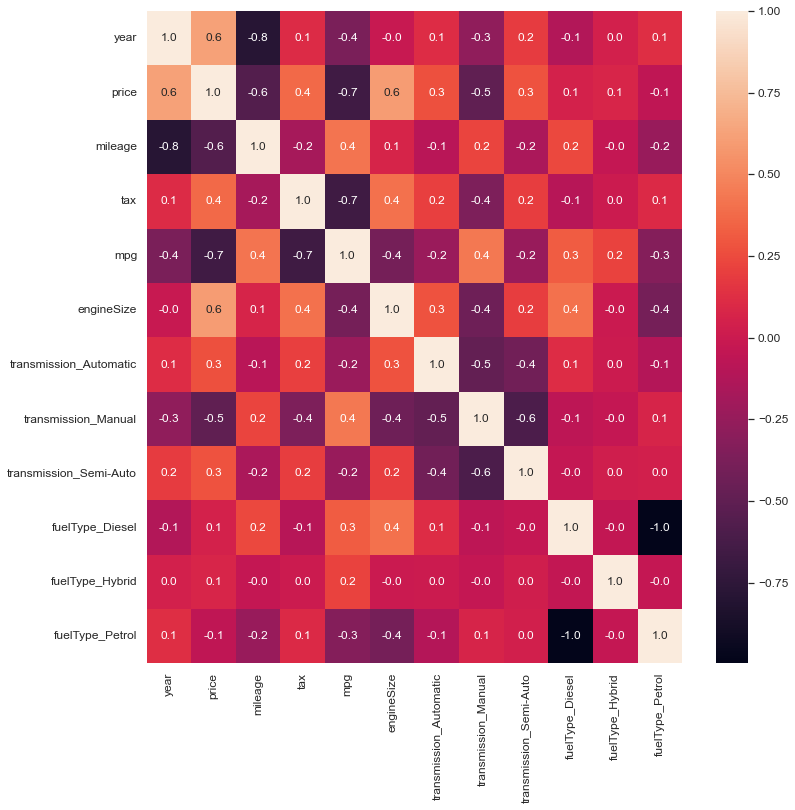

In [15]:
plt.figure(figsize=(12, 12))
sns.heatmap(data_ohc.corr(), annot=True, fmt=".1f");

Since the goal is to predict the price, one can plot the correlation values between the different features and the car price:

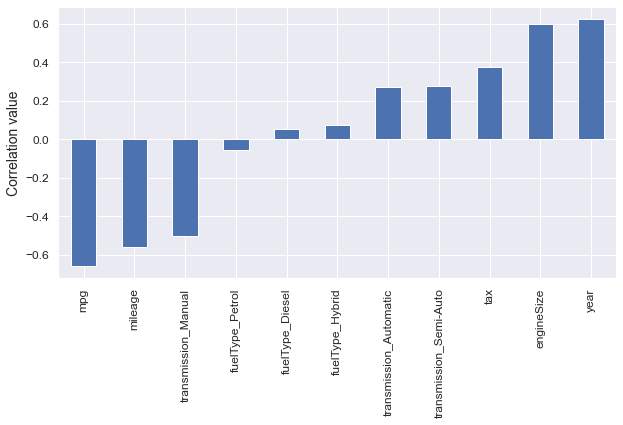

In [16]:
price_corr_val_ohc = data_ohc.corr()["price"].sort_values()[:-1]

fig = plt.figure(figsize=(10, 5))

price_corr_val_ohc.plot(kind="bar").set(ylabel="Correlation value");

<a id='find'></a>
## 3.3 Key findings

The previous sections presented the EDA approach to this dataset. There are no null values, but there are outliers. Some of them have been removed to enable fitting more accurate models.
No feature shows a correlation value greater than 0.6. The following sections present different models using the numeric features only and the one-hot-encoding data. 



[Return to menu](#table_contents)

<a id='lin_reg_basel'></a>

# 4. Linear regression - Baseline

The goal of this section is to perform simple linear regression to get the baseline. I created two models: one for the numeric data only and one for the one-hot-encoded dataframe. In the graphs above we saw that the one-hot-encoded variables had a low degree of correlation with the price, but I want to check how they perform when used together with the numeric data columns.

<a id='kfold'></a>
## 4.1 Split data - K-fold cross validation

The first step in creating a linear regression model is to split the data. I chose a K-fold cross validation approach to avoid overfitting for a particular train-test data split. For the initial one-hot-encoding dataset I used leave-one-out cross validation, but it wasn't a sustainable approach for this dataset as it took around 2 minutes to run to yield slightly more accurate results.

In [17]:
# Create X and y data for the different models
predict_column = "price"


mask = data.dtypes != object
feature_columns = [x for x in data.columns[mask] if x != predict_column]
X_data = data[feature_columns]
y_data = data[predict_column]

feature_columns = [x for x in data_ohc.columns if x != predict_column]
X_data_ohc = data_ohc[feature_columns]
y_data_ohc = data_ohc[predict_column]

X_data.head()

,year,mileage,tax,mpg,engineSize
0,2017,15735,150,55.4,1.4
1,2016,36203,20,64.2,2.0
2,2016,29946,30,55.4,1.4
3,2017,25952,145,67.3,2.0
4,2019,1998,145,49.6,1.0


In [18]:
X_data_ohc.head()

,year,mileage,tax,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,2017,15735,150,55.4,1.4,0,1,0,0,0,1
1,2016,36203,20,64.2,2.0,1,0,0,1,0,0
2,2016,29946,30,55.4,1.4,0,1,0,0,0,1
3,2017,25952,145,67.3,2.0,1,0,0,1,0,0
4,2019,1998,145,49.6,1.0,0,1,0,0,0,1


The next cell splits data into subsamples using the `Kfold` object from the sklearn library. Other than that, it includes multiple `print` statements to make sure that the test and train indeces are the same despite using different `X_data` values.

In [19]:
num_splits = 4

kf = KFold(shuffle=True, random_state=27, n_splits=num_splits)

for train_index, test_index in kf.split(X_data):
    print("Train index (Data):", train_index[:10], len(train_index))
    print("Test index (Data):", test_index[:10], len(test_index))
    print("")
    break

for train_index, test_index in kf.split(X_data_ohc):
    print("Train index (Data ohc):", train_index[:10], len(train_index))
    print("Test index (Data ohc):", test_index[:10], len(test_index))
    print("")
    break

Train index (Data): [ 1  3  4  5  7  9 11 13 15 16] 7926
Test index (Data): [ 0  2  6  8 10 12 14 18 27 30] 2642

Train index (Data ohc): [ 1  3  4  5  7  9 11 13 15 16] 7926
Test index (Data ohc): [ 0  2  6  8 10 12 14 18 27 30] 2642



<a id='lin_reg_bas_num'></a>

## 4.2 Numeric data only

The first model uses the numeric-type columns only to predict the price.

In [20]:
def linear_reg(X_data):
    scores = []

    lr = LinearRegression()
    s = StandardScaler()

    y_test_array = np.zeros(shape=(round(data.shape[0] / num_splits), num_splits))
    y_pred_array = np.zeros(shape=(round(data.shape[0] / num_splits), num_splits))

    count = 0

    for train_index, test_index in kf.split(X_data):
        X_train, X_test, y_train, y_test = (
            X_data.iloc[train_index, :],
            X_data.iloc[test_index, :],
            y_data[train_index],
            y_data[test_index],
        )

        X_train_s = s.fit_transform(X_train)

        lr.fit(X_train_s, y_train)

        X_test_s = s.transform(X_test)

        y_pred = lr.predict(X_test_s)

        y_test_array[:, count] = y_test
        y_pred_array[:, count] = y_pred

        score = r2_score(y_test.values, y_pred)

        scores.append(score)

        count = count + 1

    return (scores, y_test_array, y_pred_array)

In [21]:
scores_no_ohc, y_test_array, y_pred_array = linear_reg(X_data)

print(np.mean(scores_no_ohc))

0.8228244729368613


Let's plot the predicted values by the four subsamples and compare them with the original `y_test` values:

In [22]:
def plot_predicted_values(y_test, y_pred):

    figure, axes = plt.subplots(2, 2, figsize=(15, 14))
    axes = axes.flatten()

    for ind, ax in enumerate(axes):
        sns.scatterplot(
            ax=ax, x=y_test[:, ind], y=y_pred[:, ind], color="blue", alpha=0.6
        )

        ax.set_xlabel("Actual price value ($)")
        ax.set_ylabel("Predicted price value ($)")

        ax.set_title("K-fold subsample number " + str(ind + 1))

    fig.tight_layout()

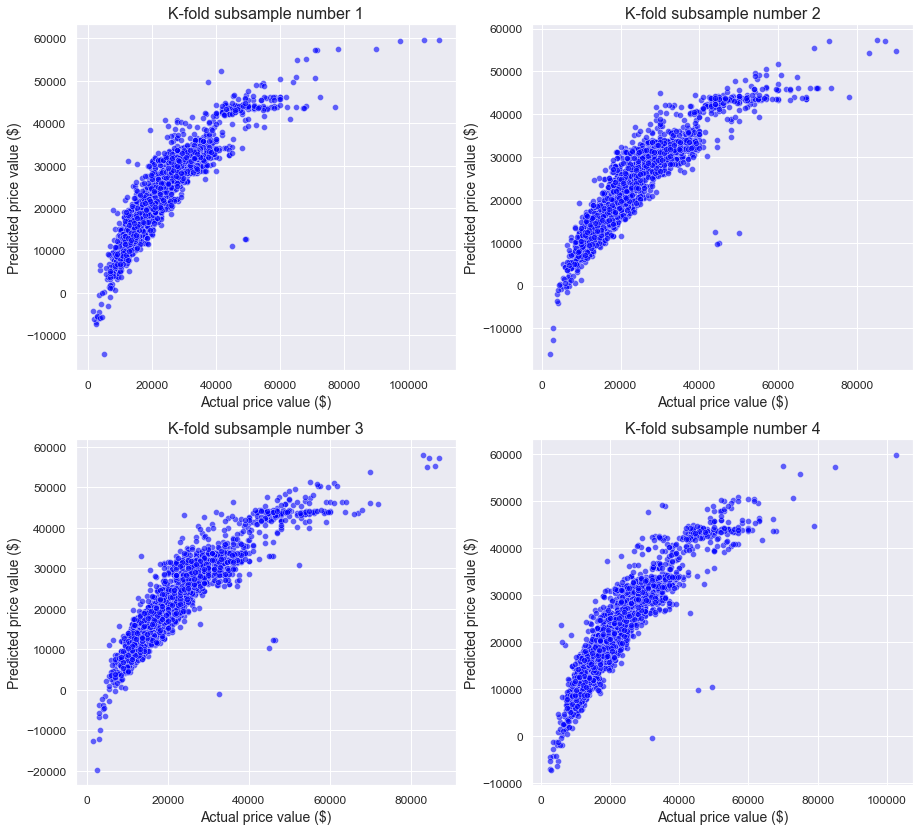

In [23]:
plot_predicted_values(y_test_array, y_pred_array)

The graphs show that the model fails to predict car prices for values beyond £60,000 and, most importantly, there are negative values! While there is nothing that prevents the model from predicting negative values, car prices cannot be negative. Therefore, the number of negative predictions can be used as a performance measure of the models, which is included at the end of the section.

<a id='lin_reg_bas_ohc'></a>

## 4.3 One-hot-encoding data

The next step is to perform linear regression using the dataframe whose categorical columns were encoded and compare it with the initial result.

In [24]:
scores_ohc, y_test_array_ohc, y_pred_array_ohc = linear_reg(X_data_ohc)

print(np.mean(scores_ohc))

0.8412935747205734


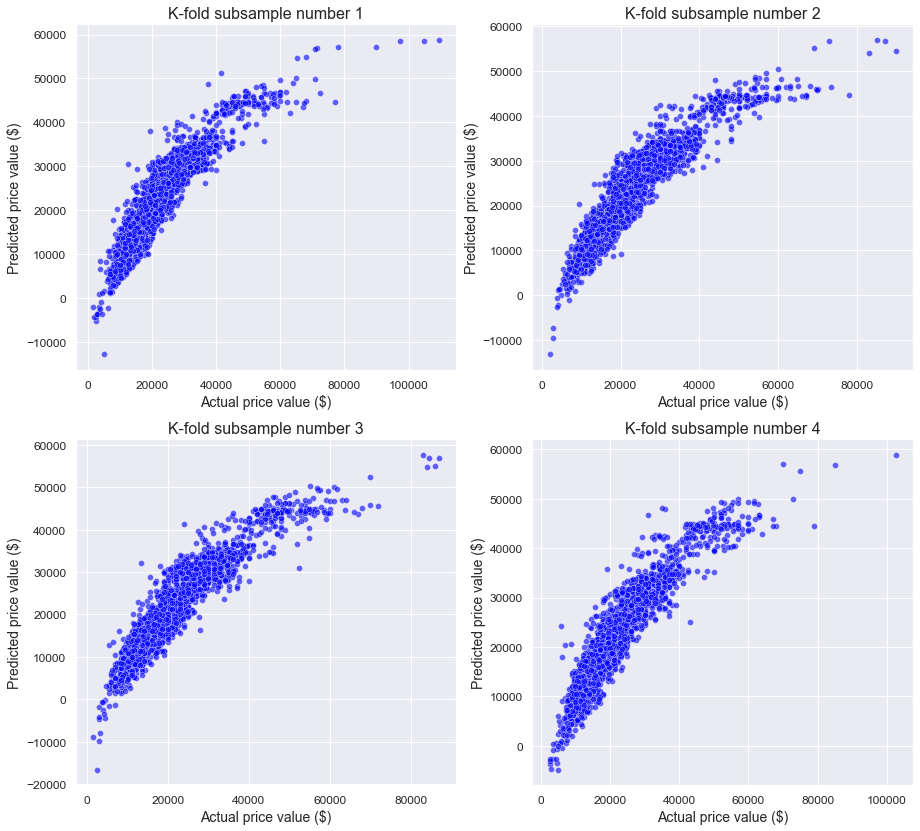

In [25]:
plot_predicted_values(y_test_array_ohc, y_pred_array_ohc)

<a id='lin_reg_bas_find'></a>

## 4.5 Key findings

The results for the numeric-data-only dataframe and the one-hot-encoding dataframe are summarised by the next table:

In [26]:
sum(sum(y_pred_array < 0))
sum(sum(y_pred_array_ohc < 0))

summary = pd.DataFrame(
    {
        "type": ["Numeric data", "Numeric data & OHC"],
        "r2_score": [np.mean(scores_no_ohc), np.mean(scores_ohc)],
        "negative_values": [sum(sum(y_pred_array < 0)), sum(sum(y_pred_array_ohc < 0))],
    }
)

summary

,type,r2_score,negative_values
0,Numeric data,0.822824,61
1,Numeric data & OHC,0.841294,47


Based on that table, the shorter version of the one-hot-encoding data makes a more accurate linear model 

[Return to menu](#table_contents)

<a id='lin_reg_pol'></a>

# 5 Linear regression - Polynomial features

The next step is to perform a linear model whose data has been transformed before to include polynomial interactions between the features

<a id='lin_reg_pol_num'></a>

## 5.1 Numeric data

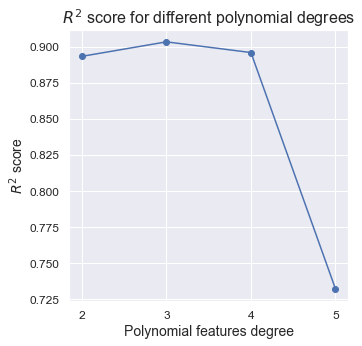

In [29]:
scores_pf = []


deg_array = np.arange(2, 6)

lr = LinearRegression()
s = StandardScaler()

predictions_val = np.zeros(shape=(len(data), len(deg_array)))

for ind, deg in enumerate(deg_array):
    pf = PolynomialFeatures(degree=deg)

    estimator = Pipeline(
        [("polynomial_features", pf), ("scaler", s), ("regression", lr)]
    )

    predictions = cross_val_predict(estimator, X_data, y_data, cv=kf)

    predictions_val[:, ind] = predictions

    score = r2_score(y_data, predictions)
    scores_pf.append(score)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(deg_array, scores_pf, "o-")
ax.set_xticks([2, 3, 4, 5])
ax.set_xlabel("Polynomial features degree")
ax.set_ylabel("$R^2$ score")
ax.set_title("$R^2$ score for different polynomial degrees");

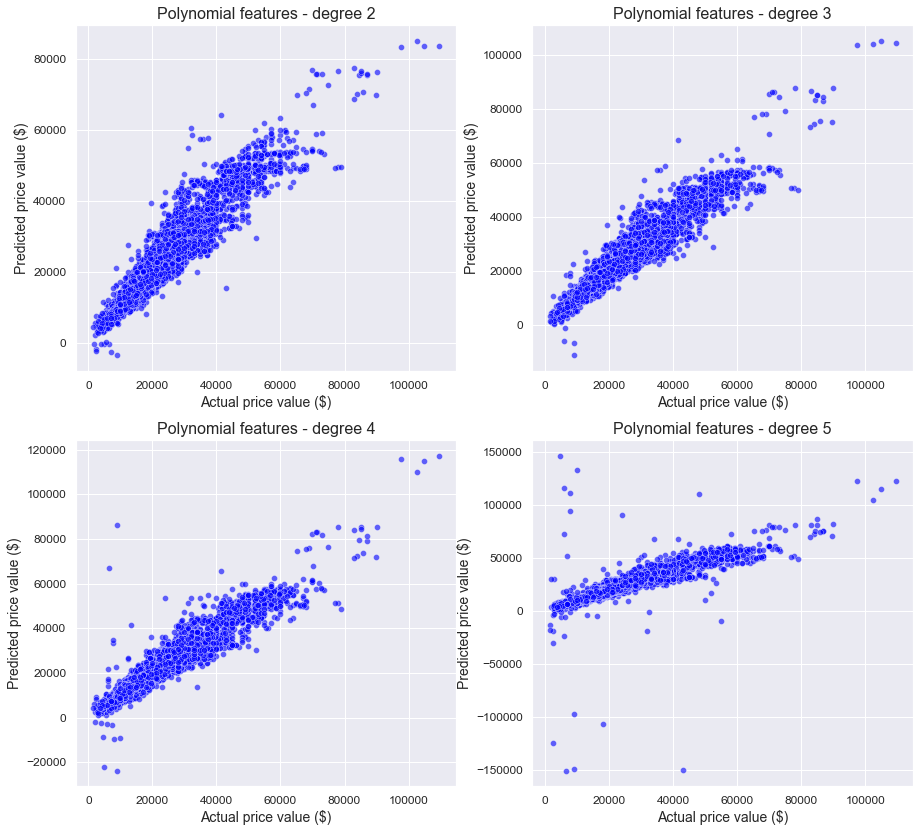

In [30]:
figure, axes = plt.subplots(2, 2, figsize=(15, 14))

axes = axes.flatten()

for ind, ax in enumerate(axes):
    sns.scatterplot(ax=ax, x=y_data, y=predictions_val[:, ind], color="blue", alpha=0.6)

    ax.set_xlabel("Actual price value ($)")
    ax.set_ylabel("Predicted price value ($)")

    ax.set_title("Polynomial features - degree " + str(ind + 2))

fig.tight_layout()

<a id='lin_reg_pol_ohc_short'></a>
## 5.2 One-hot-encoding data - smaller dataframe


In [34]:
scores_pf_ohc = []
lr = LinearRegression()
s = StandardScaler()

deg_array_ohc = np.arange(2, 5)

predictions_val_ohc = np.zeros(shape=(len(data), len(deg_array)))


for ind, deg in enumerate(deg_array_ohc):
    pf = PolynomialFeatures(degree=deg)

    estimator = Pipeline(
        [("polynomial_features", pf), ("scaler", s), ("regression", lr)]
    )

    predictions_ohc = cross_val_predict(
        estimator, X_data_ohc, y_data_ohc, cv=kf
    )

    predictions_val_ohc[:, ind] = predictions_ohc

    score_ohc = r2_score(y_data_ohc, predictions_ohc)
    scores_pf_ohc.append(score_ohc)

print(scores_pf_ohc)

[-469587311550.5571, -13935991103.767, -9.109796564047033e+19]


Again, abnormal $R^2$ values that show that the model cannot converge.

<a id='lin_reg_pol_find'></a>

## 5.3 Key insights

The results of the linear regression using only the numeric-type columns can be summarised as follows:

In [35]:
neg_val_pf = [sum(predictions_val[:, x - 2] < 0) for x in deg_array]

summary_pf = pd.DataFrame(
    {"pf degree": deg_array, "r2_quared": scores_pf, "negative_values": neg_val_pf}
)
summary_pf

,pf degree,r2_quared,negative_values
0,2,0.893238,8
1,3,0.903270,4
2,4,0.895869,9
3,5,0.732297,22


Based on those results, a third degree polynomial interaction of the features yields the best model

[Return to menu](#table_contents)

<a id='lin_reg_reg'></a>

# 6. Linear regression - Regularisation

This section presents linear regression models using regularisation. The models in this section use Ridge as the regularisation method. I tried using LASSO for some of the models and it didn't improve the results calculated using Ridge. Furthermore, it took way longer to run. Therefore, it wasn't included in this notebook

<a id='lin_reg_reg_num'></a>

## 6.1 Numeric data


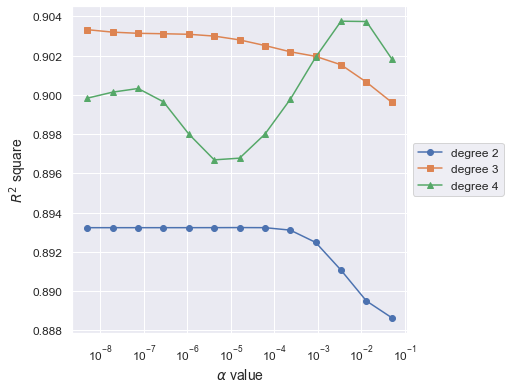

In [36]:
scores_rid = []


alpha_array = np.geomspace(5e-9, 0.5e-1, num=13)
deg_array = [2, 3, 4]


predictions_val_rid = np.zeros(shape=(len(data), len(alpha_array)))

for ind_deg, deg_val in enumerate(deg_array):
    for ind, alpha_val in enumerate(alpha_array):
        pf = PolynomialFeatures(degree=deg_val)

        rid = Ridge(alpha=alpha_val)

        estimator = Pipeline(
            [("polynomial_features", pf), ("scaler", s), ("ridge_regression", rid)]
        )

        predictions = cross_val_predict(estimator, X_data, y_data, cv=kf)

        predictions_val_rid[:, ind] = predictions

        score = r2_score(y_data, predictions)
        scores_rid.append(score)

# Plot the r square values vs the alpha values
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(alpha_array, scores_rid[: len(alpha_array)], "o-", label="degree 2")
ax.plot(
    alpha_array,
    scores_rid[len(alpha_array) : 2 * len(alpha_array)],
    "s-",
    label="degree 3",
)
ax.plot(alpha_array, scores_rid[2 * len(alpha_array) :], "^-", label="degree 4")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_xscale("log")

ax.set_ylabel("$R^2$ square")
ax.set_xlabel(r"$\alpha$ value");

<a id='lin_reg_reg_ohc'></a>

## 6.2 One-hot-encoding data

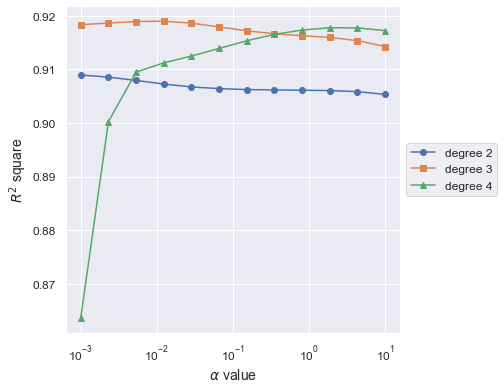

In [44]:
scores_rid_ohc = []


alpha_array = np.geomspace(1e-3, 10, num=12)
deg_array = [2, 3, 4]


predictions_val_rid_ohc = np.zeros(shape=(len(data_ohc), len(alpha_array)))

for ind_deg, deg_val in enumerate(deg_array):
    for ind, alpha_val in enumerate(alpha_array):
        pf = PolynomialFeatures(degree=deg_val)

        rid = Ridge(alpha=alpha_val)

        estimator = Pipeline(
            [("polynomial_features", pf), ("scaler", s), ("ridge_regression", rid)]
        )

        predictions = cross_val_predict(
            estimator, X_data_ohc, y_data_ohc, cv=kf
        )

        predictions_val_rid_ohc[:, ind] = predictions

        score = r2_score(y_data, predictions)
        scores_rid_ohc.append(score)

# Plot the r square values vs the alpha values
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(alpha_array, scores_rid_ohc[: len(alpha_array)], "o-", label="degree 2")
ax.plot(
    alpha_array,
    scores_rid_ohc[len(alpha_array) : 2 * len(alpha_array)],
    "s-",
    label="degree 3",
)
ax.plot(alpha_array, scores_rid_ohc[2 * len(alpha_array) :], "^-", label="degree 4")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_xscale("log")

# ax.set_ylim(0.8, 0.93)

ax.set_ylabel("$R^2$ square")
ax.set_xlabel(r"$\alpha$ value");

<a id='lin_reg_reg_best'></a>

## 6.4 Ridge regression - best fit

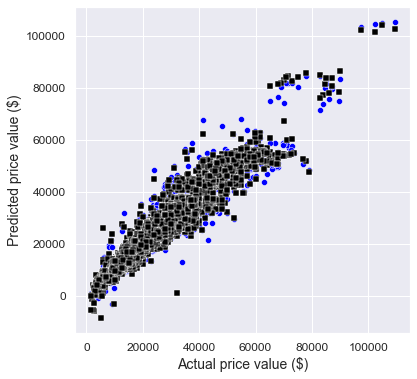

In [45]:
pf = PolynomialFeatures(degree=4)
pf_ohc = PolynomialFeatures(degree=3)

s = StandardScaler()
lr = LinearRegression()

rid = Ridge(alpha=1e-2)

# Calculate the prediction values and the r2 score for the numeric dataframe
estimator = Pipeline(
    [("polynomial_features", pf), ("scaler", s), ("ridge_regression", rid)]
)

predictions = cross_val_predict(estimator, X_data, y_data, cv=kf)

score = r2_score(y_data, predictions)

# Calculate the prediction values and the r2 score for the numeric dataframe
rid_ohc = Ridge(alpha=1e-2)

estimator_ohc = Pipeline(
    [("polynomial_features", pf_ohc), ("scaler", s), ("ridge_regression", rid_ohc)]
)

predictions_ohc = cross_val_predict(estimator_ohc, X_data_ohc, y_data_ohc, cv=kf)

score_ohc = r2_score(y_data, predictions_ohc)




# Plot the predictions
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(ax=ax, x=y_data, y=predictions, color="blue")
sns.scatterplot(ax=ax, x=y_data, y=predictions_ohc, color="black", marker="s")


ax.set_xlabel("Actual price value ($)")
ax.set_ylabel("Predicted price value ($)");

In [48]:
# Importing library
from scipy.stats import skew

In [49]:
resid_pf = y_data - predictions_val[:,1]
resid_rid = y_data - predictions
resid_rid_ohc = y_data - predictions_ohc


In [50]:
print(skew(resid_pf, axis=0, bias=True))
print(skew(resid_rid, axis=0, bias=True))
print(skew(resid_rid_ohc, axis=0, bias=True))


0.3267245398563513
0.3612755276416128
0.5917179192686797


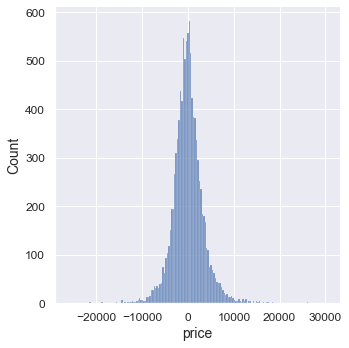

In [51]:
sns.displot(resid_rid)

(-2.5, 2.5)

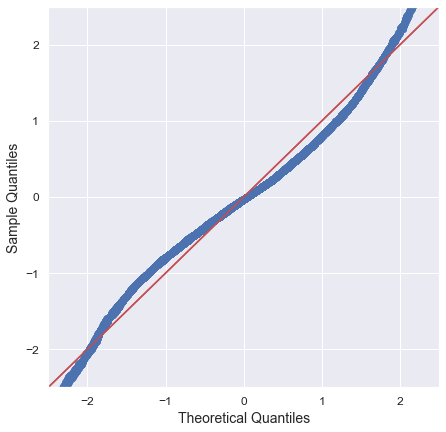

In [55]:
f, ax = plt.subplots(figsize=(7,7))

# call the qqplot graph from statsmodels 'graphics' module.
# fits against the normal distribution as standard.
sm.graphics.qqplot(resid_pf, line='45', fit=True, ax=ax)
sm.graphics.qqplot(resid_rid, line='45', fit=True, ax=ax)

ax.set_xlim(left=-2.5, right=2.5)
ax.set_ylim(bottom=-2.5, top=2.5)

<AxesSubplot:xlabel='price', ylabel='price'>

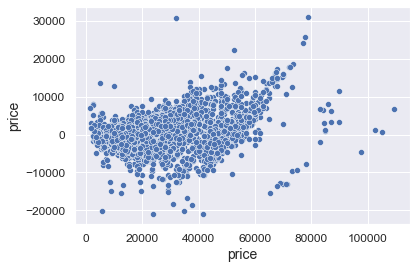

In [53]:
sns.scatterplot(x=y_data, y=resid_rid_ohc)

<a id='lin_reg_reg_find'></a>

## 6.5 Key findings

In [54]:
summary_ridge = pd.DataFrame(
    {
        "type": ["Numeric data", "Numeric data & OHC"],
        "degree": [4, 3],
        "r2_quared": [score, score_ohc],
        "negative_values": [
            sum(predictions < 0),
            sum(predictions_ohc < 0),
        ],
    }
)
summary_ridge

,type,degree,r2_quared,negative_values
0,Numeric data,4,0.903939,4
1,Numeric data & OHC,3,0.919032,9


[Return to menu](#table_contents)

<a id='insights'></a>

## 7. Key insights, recommendations and next steps

Having presented different approaches to linear regression, the best overall model is a simple linear regression with a degree 4 polynomial interaction between the features. This particular model doesn't have the largest $R^2$ value, but it has the lowest number of negative price values. Using regularisation leads to larger $R^2$ values, but there are more negative price predictions.

Following this analysis, I believe that some actions could be implemented differently to yield a better outcome. For example, a more in depth analysis of outliers could lead to better results. I focused on the largest values for the outliers, but removing very low values could help reduce the number of negative prediction values. 

Something else that could be improved is the test cross-validation strategy. Since there are some extreme values in the dataset, K-fold cross validation might lead to less accurate results.

Next steps:
* Perform a deeper analysis of outliers
* Use stratified Kfold or Leave-one-out cross validation to include more representative values in each sub-sample
* Include a ElasticNet model to levarage the best of Lasso and Ridge


[Return to menu](#table_contents)